## Import Required Packages

In [ ]:
#install libraries

!rm -r kdg
!git clone https://github.com/neurodata/kdg
!ls
!pip install kdg/.

In [ ]:
# import modules
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from matplotlib.ticker import ScalarFormatter

from kdg.kdn import *
from kdg.utils import *

## Prepare dataset (Gaussian 2D Parity)

In [ ]:
# Define the experimental setup.
# We will be using a Gaussian sparse parity setup
# You can change these parameters.

n_train = 2000
n_test = 1000

#XOR
X1, y1 = generate_gaussian_parity(n_train)
X1_test, y1_test = generate_gaussian_parity(n_test)

#XNOR
X2, y2 = generate_gaussian_parity(n_train)
X2_test, y2_test = generate_gaussian_parity(n_test)

y2 = -1*(y2-1)
y2_test = -1*(y2_test-1)

## Raw Neural Network

In [ ]:
# Define our neural network parameters

def getNN(dense_size, input_size, **kwargs):
    network_base = keras.Sequential()
    network_base.add(layers.Dense(dense_size, activation='relu', input_shape=(input_size,)))
    network_base.add(layers.Dense(dense_size, activation='relu'))
    network_base.add(layers.Dense(units=2, activation = 'softmax'))
    network_base.compile(**kwargs)
    return network_base

dense_layer_nodes = 5

# NN params
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
fit_kwargs = {"epochs": 150, "batch_size": 32, "verbose": False}


# Fit two neural networks using our test data and print accuracy
nn1 = getNN(dense_layer_nodes, 2, **compile_kwargs)
nn1.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
y1_hat = np.argmax(nn1.predict(X1_test), axis=1)

print(f"NN1 Accuracy: {np.mean(y1_hat == y1_test)}")

nn2 = getNN(dense_layer_nodes, 2, **compile_kwargs)
nn2.fit(X2, keras.utils.to_categorical(y2), **fit_kwargs)
y2_hat = np.argmax(nn2.predict(X2_test), axis=1)

print(f"NN2 Accuracy: {np.mean(y2_hat == y2_test)}")

y2_mismatch = np.argmax(nn1.predict(X2_test), axis=1)
print(f"NN1 Accuracy on X2 data: {np.mean(y2_mismatch == y2_test)}")

#Well that's garbage. Let's see if we can do better.

NN1 Accuracy: 0.947
NN2 Accuracy: 0.956
NN1 Accuracy on X2 data: 0.045


## Kernel Density Network Forward Transfer


### Test Functions

In [ ]:
def forward_transfer(X, y, last_means, last_covs, k = 1.0):
    r"""
    Re-assign labels, sizes to previous polytopes based on current data

    Parameters:
    -----------
    X: ndarray
        Input data matrix; training data for current task
    y : ndarray
        Output (i.e. response) data matrix for current task
    last_means: ndarray
        Means for previous polytopes
    last_covs: ndarray
        Covariances for previous polytopes

    Returns:
    ----------
    polytope_sizes : new sample counts for polytopes
    polytope_labels : new labels for polytopes
    """

    X = check_array(X)
    labels = np.unique(y)

    #likelihood = X_ members by nPolytopes
    likelihood = []

    # Edited from _compute_pdf
    # Get likelihoods for each pdf
    for polytope_idx in range(last_means.shape[0]):
        polytope_mean = last_means[polytope_idx]
        polytope_cov = last_covs[polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )
        
        likelihood.append(var.pdf(X))

    likelihood = np.array(likelihood)
    
    proba = np.argmax(likelihood, axis=0)
    proba_by_label = [proba[y == L] for L in labels]

    polytope_counts = np.zeros((labels.shape[0], last_means.shape[0]))
    for label in labels:
        polytope_idxs = np.unique(proba_by_label[label])
        for count, idx in enumerate(polytope_idxs):
            polytope_counts[label, idx] = np.sum(proba_by_label[label] == idx)

    polytope_sizes = polytope_counts

    #method 1: by label
    #bias = {}
    #for label in labels:
    #    biases = np.min(likelihood[:, y==label], axis=1) * polytope_sizes[label]
    #    bias[label] = sum(biases)/(k*sum(polytope_sizes[label]))
    #bias = min(bias.values())

    #method 2: average across all
    bias = sum(np.min(likelihood, axis=1) * np.sum(polytope_sizes, axis=0))/k*len(y)

    return polytope_sizes, bias

In [ ]:
#Some KDN functions externalized for easier testing/editing
def _compute_pdf(X, polytope_id, polytope_means, polytope_covs):
    r"""compute the likelihood for the given data
    Parameters
    ----------
    X : ndarray
        Input data matrix
    label : int
        class label
    polytope_idx : int
        polytope identifier
    Returns
    -------
    ndarray
        likelihoods
    """
    polytope_mean = polytope_means[polytope_id]
    polytope_cov = polytope_covs[polytope_id]

    var = multivariate_normal(
        mean=polytope_mean, cov=polytope_cov, allow_singular=True
    )

    likelihood = var.pdf(X)
    return likelihood

def predict_proba2(X,
                   polytope_means,
                   polytope_covs,
                   polytope_sizes,
                   priors,
                   bias,
                   return_likelihoods=False):
    r"""
    Calculate posteriors using the kernel density network.
    Parameters
    ----------
    X : ndarray
        Input data matrix.
    """
    X = check_array(X)

    labels = np.arange(0, polytope_sizes.shape[0])

    likelihoods = np.zeros((np.size(X, 0), len(labels)), dtype=float)
    priors = np.reshape(priors, (len(priors), 1))

    for label in labels:
        for polytope, size in enumerate(polytope_sizes[label, :]):
            likelihoods[:, label] += np.nan_to_num(
                size * _compute_pdf(X, polytope, polytope_means, polytope_covs)
            )
        likelihoods[:, label] += bias
    proba = (
        likelihoods.T * priors / (np.sum(likelihoods.T * priors, axis=0) + 1e-100)
    ).T
    if return_likelihoods:
        return proba, likelihoods
    else:
        return proba

In [ ]:
# Helper functions for testing

# Add noise to other shapes besides Gaussian sparse parity
def add_noise(X, p = 20, center_box = (-1.0, 1.0)):
    shape = X.shape

    X_noise = np.random.uniform(
        low=center_box[0], high=center_box[1], size=(X.shape[0], p - X.shape[1])
    )
    X = np.concatenate((X, X_noise), axis=1)

    return X

def test_forward_transfer(X, y, kdn, X_test = None, y_test = None,
                          verbose = True, return_summary = True):
    if X_test is None: X_test = X
    if y_test is None: y_test = y

    #flatten polytope information
    means = np.concatenate([val for (key, val) in kdn.polytope_means.items()])
    covs = np.concatenate([val for (key, val) in kdn.polytope_covs.items()])
    #labels_by_task = np.concatenate([np.ones(len(val))*key for (key, val) in kdn.polytope_means.items()])

    #test
    #sizes, labels = forward_transfer(X, y, means, covs)
    sizes, bias = forward_transfer(X, y, means, covs)

    priors = []
    for label in np.unique(y_test):
        priors.append(np.sum(y_test == label))
    priors = priors/np.sum(priors)

    raw = kdn.predict_proba(X_test)
    transfer = predict_proba2(X_test, means, covs, sizes, priors, bias)

    if return_summary:
        raw_m = np.mean(np.argmax(raw, axis = 1) == y_test)
        transfer_m = np.mean(np.argmax(transfer, axis = 1) == y_test)

        if verbose:
            print(f"NN Accuracy on Task 2 data without transfer: {raw_m}")
            print(f"NN Accuracy on Task 2 data after forward transfer: {transfer_m}")
        return raw_m, transfer_m

    else:
        if verbose:
            print(f"Returning posteriors.")
        return raw, transfer

def plot_accuracy(sample_size, pct_errs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    color_list = [(1.0, 0.0, 0.0), (0.0, 0.0, 0.0)]
    color_list.extend(sns.color_palette("Set1")[1:])

    for i, err in enumerate(pct_errs):
        ax.plot(sample_size, np.mean(err, axis=1), c=color_list[i], label=labels[i])
        ax.fill_between(
            sample_size,
            np.quantile(err, 0.25, axis=1),
            np.quantile(err, 0.75, axis=1),
            facecolor=color_list[i],
            alpha=0.3,
        )
    
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

    ax.set_xscale("log")
    ax.set_xlabel("Sample size")
    ax.set_ylabel("Percent Error")
    ax.legend(frameon=False)

### Test Algorithm

In [ ]:
#Get initial KDN
kdn1 = kdn(network=nn1)
kdn1.fit(X1, y1)

#Test on new data
test_forward_transfer(X2, y2, kdn1)

NN Accuracy on Task 2 data without transfer: 0.045
NN Accuracy on Task 2 data after forward transfer: 0.9555


(0.045, 0.9555)

In [ ]:
#Test fitting to ellipse

X3, y3 = generate_ellipse(n_test)

#Try again
test_forward_transfer(X3, y3, kdn1)

NN Accuracy on Task 2 data without transfer: 0.474
NN Accuracy on Task 2 data after forward transfer: 0.561


(0.474, 0.561)

## Experiments

### XNOR Test

Testing with 100 samples
Task2 KDN Accuracy: [0.76, 0.76, 0.82, 0.67, 0.78, 0.76, 0.62, 0.73, 0.71, 0.74]
Task1 Accuracy on Task 2: [0.07, 0.09, 0.07, 0.08, 0.03, 0.06, 0.06, 0.07, 0.04, 0.04]
Forward Transfer Accuracy on Task 2: [0.83, 0.88, 0.88, 0.76, 0.82, 0.86, 0.8, 0.86, 0.85, 0.85]
Testing with 200 samples
Task2 KDN Accuracy: [0.76, 0.73, 0.78, 0.835, 0.76, 0.765, 0.835, 0.795, 0.855, 0.795]
Task1 Accuracy on Task 2: [0.055, 0.065, 0.065, 0.065, 0.045, 0.06, 0.07, 0.05, 0.05, 0.055]
Forward Transfer Accuracy on Task 2: [0.86, 0.865, 0.86, 0.87, 0.8, 0.825, 0.89, 0.89, 0.91, 0.885]
Testing with 300 samples
Task2 KDN Accuracy: [0.8433333333333334, 0.8466666666666667, 0.8766666666666667, 0.9033333333333333, 0.7966666666666666, 0.8, 0.8566666666666667, 0.8366666666666667, 0.7766666666666666, 0.8733333333333333]
Task1 Accuracy on Task 2: [0.043333333333333335, 0.03666666666666667, 0.04666666666666667, 0.06333333333333334, 0.05, 0.06333333333333334, 0.05333333333333334, 0.043333333333

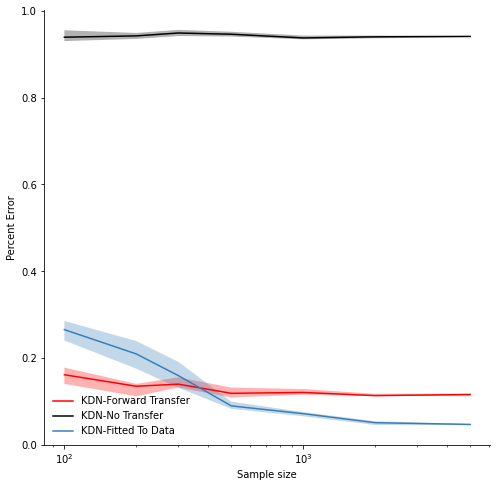

In [ ]:
accuracy_task1 = []
accuracy_forward = []
accuracy_kdn = []

p = 10
p_star = 2
sample_size = [100, 200, 300, 500, 1000, 2000, 5000]
reps = 10

test_size = min(sample_size)

# Run tests

X1, y1 = gaussian_sparse_parity(500, p_star = p_star, p = p)
raw_nn = getNN(dense_layer_nodes, p, **compile_kwargs)
raw_nn.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task1 = kdn(network = raw_nn, verbose=False)
kdn_task1.fit(X1, y1)

for s in sample_size:
    print(f"Testing with {s} samples")
    for r in range(reps):
        #XNOR
        X_train, y_train = gaussian_sparse_parity(s, p_star = p_star, p = p)
        X_test, y_test = gaussian_sparse_parity(s, p_star=p_star, p=p)
        
        y_train = -1*(y_train-1)
        y_test = -1*(y_test-1)

        #Original KDN to serve as a baseline
        nn_test = getNN(dense_layer_nodes, p, **compile_kwargs)
        nn_test.fit(X_train, keras.utils.to_categorical(y_train), **fit_kwargs)
        kdn_test = kdn(network = nn_test)
        kdn_test.fit(X_train, y_train)
        accuracy_kdn.append(np.mean(kdn_test.predict(X_test) == y_test))

        #Task1 KDN with Forward Transfer
        raw, forward = test_forward_transfer(X_train,
                                             y_train,
                                             kdn_task1,
                                             X_test = X_test,
                                             y_test = y_test,
                                             verbose = False)
        accuracy_task1.append(raw)
        accuracy_forward.append(forward)


    print("Task2 KDN Accuracy:", accuracy_kdn[-reps:])
    print("Task1 Accuracy on Task 2:", accuracy_task1[-reps:])
    print("Forward Transfer Accuracy on Task 2:", accuracy_forward[-reps:])

# Plot results
shape = (len(sample_size), reps)
err_kdn = 1 - np.array(accuracy_kdn).reshape(shape)
err_task1 = 1 - np.array(accuracy_task1).reshape(shape)
err_forward = 1 - np.array(accuracy_forward).reshape(shape)

error_rates = (err_forward, err_task1, err_kdn)
labels = ("KDN-Forward Transfer", "KDN-No Transfer", "KDN-Fitted To Data")

plot_accuracy(sample_size, error_rates, labels)

### 45-Degree XOR

Testing with 100 samples
Task2 KDN Accuracy: [0.94, 0.95, 0.93, 0.93, 0.93, 0.99, 0.94, 0.96, 0.95, 0.97]
Task1 Accuracy on Task 2: [0.56, 0.44, 0.62, 0.57, 0.47, 0.59, 0.48, 0.58, 0.54, 0.56]
Forward Transfer Accuracy on Task 2: [0.95, 0.95, 0.92, 0.94, 0.95, 0.96, 0.97, 0.97, 0.97, 0.98]
Testing with 200 samples
Task2 KDN Accuracy: [0.955, 0.965, 0.975, 0.945, 0.95, 0.955, 0.955, 0.955, 0.975, 0.925]
Task1 Accuracy on Task 2: [0.56, 0.56, 0.6, 0.54, 0.5, 0.52, 0.5, 0.53, 0.56, 0.515]
Forward Transfer Accuracy on Task 2: [0.93, 0.945, 0.965, 0.955, 0.945, 0.94, 0.96, 0.965, 0.965, 0.935]
Testing with 300 samples
Task2 KDN Accuracy: [0.95, 0.9466666666666667, 0.96, 0.9333333333333333, 0.9366666666666666, 0.94, 0.95, 0.9133333333333333, 0.9433333333333334, 0.9466666666666667]
Task1 Accuracy on Task 2: [0.5466666666666666, 0.5033333333333333, 0.55, 0.5266666666666666, 0.54, 0.5, 0.5333333333333333, 0.5266666666666666, 0.5166666666666667, 0.5266666666666666]
Forward Transfer Accuracy on T

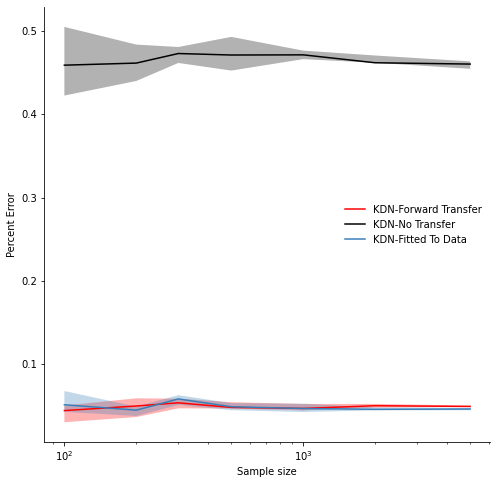

In [ ]:
accuracy_task1 = []
accuracy_forward = []
accuracy_kdn = []

#p = 10
#p_star = 2
sample_size = [100, 200, 300, 500, 1000, 2000, 5000]
reps = 10

test_size = min(sample_size)

# Run tests

#X1, y1 = gaussian_sparse_parity(500, p_star = p_star, p = p)
X1, y1 =  generate_gaussian_parity(500)
raw_nn = getNN(dense_layer_nodes, 2, **compile_kwargs)
raw_nn.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task1 = kdn(network = raw_nn, verbose=False)
kdn_task1.fit(X1, y1)

for s in sample_size:
    print(f"Testing with {s} samples")
    for r in range(reps):
        #XNOR
        X_train, y_train = generate_gaussian_parity(s, angle_params = np.pi/4)
        X_test, y_test = generate_gaussian_parity(s, angle_params = np.pi/4)

        #X_train = add_noise(X_train, p)
        #X_test = add_noise(X_test, p)

        #Original KDN to serve as a baseline
        nn_test = getNN(dense_layer_nodes, 2, **compile_kwargs)
        nn_test.fit(X_train, keras.utils.to_categorical(y_train), **fit_kwargs)
        kdn_test = kdn(network = nn_test)
        kdn_test.fit(X_train, y_train)
        accuracy_kdn.append(np.mean(kdn_test.predict(X_test) == y_test))

        #Task1 KDN with Forward Transfer
        raw, forward = test_forward_transfer(X_train,
                                             y_train,
                                             kdn_task1,
                                             X_test = X_test,
                                             y_test = y_test,
                                             verbose = False,
                                             return_summary = True)
        accuracy_task1.append(raw)
        accuracy_forward.append(forward)


    print("Task2 KDN Accuracy:", accuracy_kdn[-reps:])
    print("Task1 Accuracy on Task 2:", accuracy_task1[-reps:])
    print("Forward Transfer Accuracy on Task 2:", accuracy_forward[-reps:])

# Plot results
shape = (len(sample_size), reps)
err_kdn = 1 - np.array(accuracy_kdn).reshape(shape)
err_task1 = 1 - np.array(accuracy_task1).reshape(shape)
err_forward = 1 - np.array(accuracy_forward).reshape(shape)

error_rates = (err_forward, err_task1, err_kdn)
labels = ("KDN-Forward Transfer", "KDN-No Transfer", "KDN-Fitted To Data")

plot_accuracy(sample_size, error_rates, labels)

### Ellipse Test

Testing with 100 samples
Task2 KDN Accuracy: [0.78, 0.7, 0.65, 0.79, 0.67, 0.73, 0.67, 0.58, 0.62, 0.8]
Task1 Accuracy on Task 2: [0.55, 0.52, 0.49, 0.5, 0.52, 0.51, 0.56, 0.52, 0.53, 0.51]
Forward Transfer Accuracy on Task 2: [0.69, 0.54, 0.57, 0.61, 0.54, 0.65, 0.52, 0.55, 0.48, 0.58]
Testing with 200 samples
Task2 KDN Accuracy: [0.715, 0.77, 0.8, 0.76, 0.705, 0.78, 0.78, 0.69, 0.765, 0.655]
Task1 Accuracy on Task 2: [0.465, 0.41, 0.475, 0.495, 0.465, 0.56, 0.55, 0.535, 0.49, 0.465]
Forward Transfer Accuracy on Task 2: [0.61, 0.59, 0.635, 0.6, 0.575, 0.61, 0.58, 0.585, 0.6, 0.56]
Testing with 300 samples
Task2 KDN Accuracy: [0.8366666666666667, 0.89, 0.79, 0.7433333333333333, 0.8533333333333334, 0.6933333333333334, 0.7566666666666667, 0.7566666666666667, 0.7733333333333333, 0.7433333333333333]
Task1 Accuracy on Task 2: [0.52, 0.47333333333333333, 0.4633333333333333, 0.47333333333333333, 0.5066666666666667, 0.5066666666666667, 0.49, 0.4866666666666667, 0.49, 0.4666666666666667]
Forwar

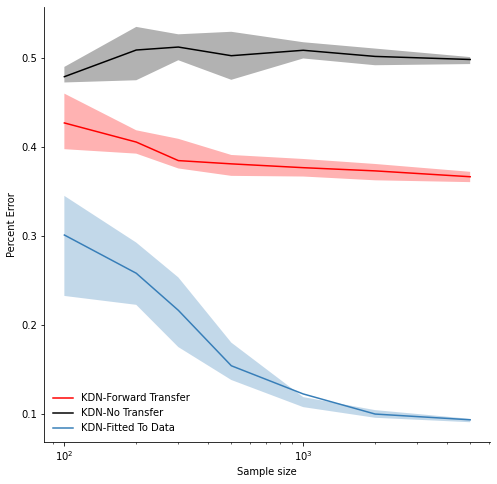

In [ ]:
accuracy_task1 = []
accuracy_forward = []
accuracy_kdn = []

sample_size = [100, 200, 300, 500, 1000, 2000, 5000]
reps = 10

test_size = min(sample_size)

# Run tests

X1, y1 =  generate_gaussian_parity(500)
raw_nn = getNN(dense_layer_nodes, 2, **compile_kwargs)
raw_nn.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task1 = kdn(network = raw_nn, verbose=False)
kdn_task1.fit(X1, y1)

for s in sample_size:
    print(f"Testing with {s} samples")
    for r in range(reps):
        #XNOR
        X_train, y_train = generate_ellipse(s)
        X_test, y_test = generate_ellipse(s)

#        X_train = add_noise(X_train, p)
#        X_test = add_noise(X_test, p)

        #Original KDN to serve as a baseline
        nn_test = getNN(dense_layer_nodes, 2, **compile_kwargs)
        nn_test.fit(X_train, keras.utils.to_categorical(y_train), **fit_kwargs)
        kdn_test = kdn(network = nn_test)
        kdn_test.fit(X_train, y_train)
        accuracy_kdn.append(np.mean(kdn_test.predict(X_test) == y_test))

        #Task1 KDN with Forward Transfer
        raw, forward = test_forward_transfer(X_train,
                                             y_train,
                                             kdn_task1,
                                             X_test = X_test,
                                             y_test = y_test,
                                             verbose = False)
        accuracy_task1.append(raw)
        accuracy_forward.append(forward)


    print("Task2 KDN Accuracy:", accuracy_kdn[-reps:])
    print("Task1 Accuracy on Task 2:", accuracy_task1[-reps:])
    print("Forward Transfer Accuracy on Task 2:", accuracy_forward[-reps:])

# Plot results
shape = (len(sample_size), reps)
err_kdn = 1 - np.array(accuracy_kdn).reshape(shape)
err_task1 = 1 - np.array(accuracy_task1).reshape(shape)
err_forward = 1 - np.array(accuracy_forward).reshape(shape)

error_rates = (err_forward, err_task1, err_kdn)
labels = ("KDN-Forward Transfer", "KDN-No Transfer", "KDN-Fitted To Data")

plot_accuracy(sample_size, error_rates, labels)

### Visualize Posteriors

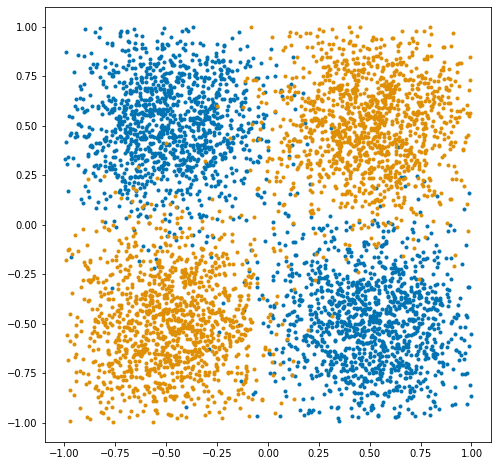

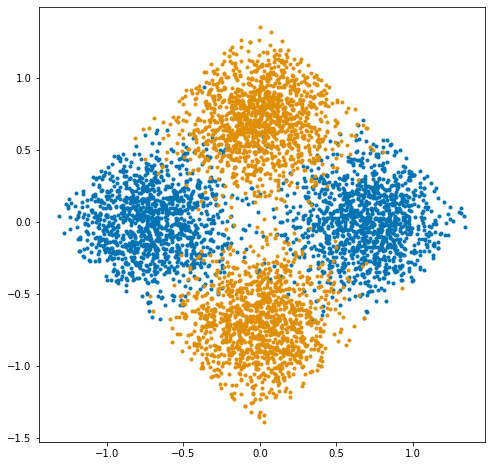

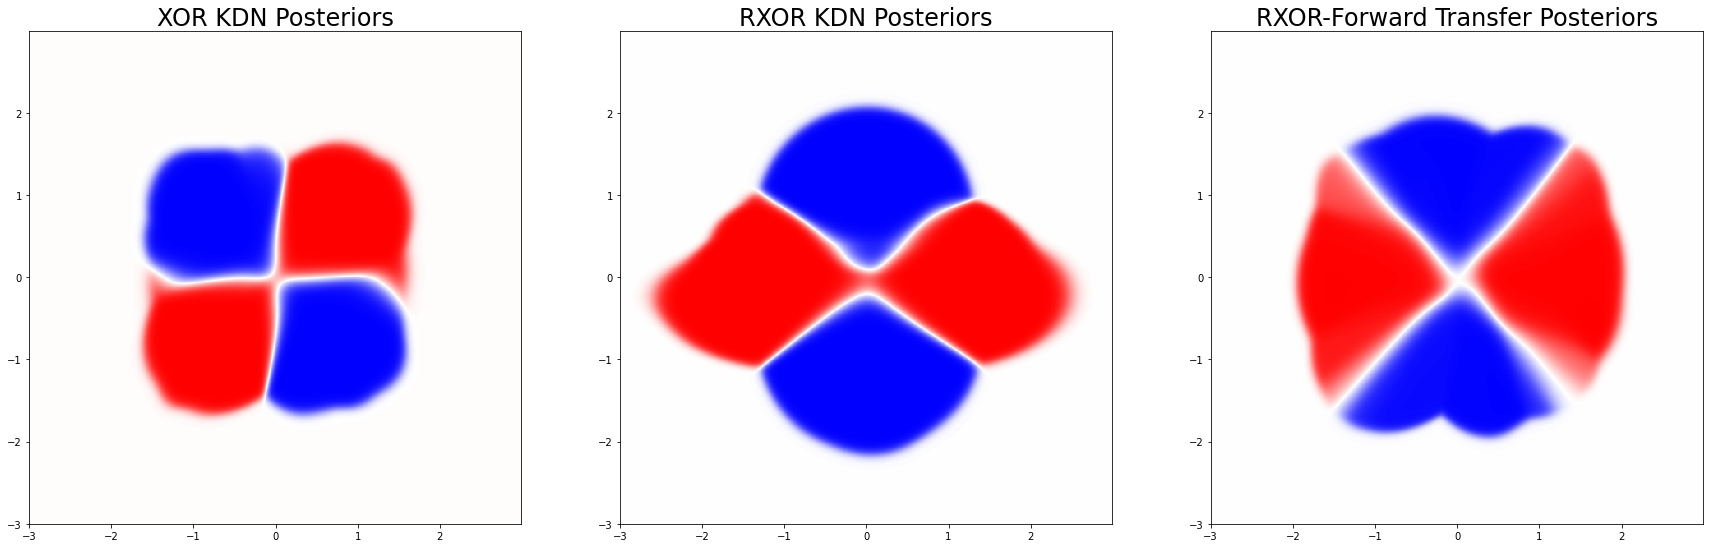

In [ ]:
X1, y1 = generate_gaussian_parity(5000)
plot_2dsim(X1, y1)

X2, y2 = generate_gaussian_parity(5000, angle_params = np.pi/4)
plot_2dsim(X2, y2)

# Get KDNs
nn1 = getNN(5, 2, **compile_kwargs)
nn1.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task1 = kdn(network = nn1, verbose=False)
kdn_task1.fit(X1, y1)

nn2 = getNN(5, 2, **compile_kwargs)
nn2.fit(X1, keras.utils.to_categorical(y1), **fit_kwargs)
kdn_task2 = kdn(network = nn2, verbose=False)
kdn_task2.fit(X2, y2)

#define grids
p = np.arange(-3, 3, step=0.01)
q = np.arange(-3, 3, step=0.01)
xx, yy = np.meshgrid(p, q)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

posterior_task1 = kdn_task1.predict_proba(grid_samples)
posterior_task2 = kdn_task2.predict_proba(grid_samples)
_, posterior_ft = test_forward_transfer(X2, y2,
                                        kdn_task1,
                                        X_test = grid_samples,
                                        verbose = False,
                                        return_summary = False)

posterior_task1 = posterior_task1[:,0].reshape(600,600)
posterior_task2 = posterior_task2[:,0].reshape(600,600)
posterior_ft = posterior_ft[:,0].reshape(600,600)

fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    posterior_task1,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("XOR KDN Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    posterior_task2,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("RXOR KDN Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    posterior_ft,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("RXOR-Forward Transfer Posteriors", fontsize=24)
ax[2].set_aspect("equal")
plt.show()

## Proglearn Figures

### Functions

In [ ]:
#Modified Proglearn functions for running KDN_FT

def run(mc_rep, n_test, n_nodes, n_xor, n_rxor, mean_error, std_error, mean_te, std_te):
    for i, n1 in enumerate(n_xor):
        print('starting to compute %s xor\n'%n1)
        error = np.array([experiment(n1, 0, task2_angle = np.pi/4) for _ in range(mc_rep)])
        mean_error[:, i] = np.mean(error, axis=0)
        std_error[:, i] = np.std(error, ddof=1, axis=0)
        mean_te[0, i] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        mean_te[1, i] = np.mean(error[:, 2]) / np.mean(error[:, 3])
        mean_te[2, i] = np.mean(error[:, 0]) / np.mean(error[:, 4])
        mean_te[3, i] = np.mean(error[:, 2]) / np.mean(error[:, 5])

        if n1 == n_xor[-1]:
            for j, n2 in enumerate(n_rxor):
                print('starting to compute %s rxor\n'%n2)
                error = np.array([experiment(n1, n2, task2_angle = np.pi/4) for _ in range(mc_rep)])

                mean_error[:, i + j + 1] = np.mean(error, axis=0)
                std_error[:, i + j + 1] = np.std(error, ddof=1, axis=0)
                mean_te[0, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 1])
                mean_te[1, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 3])
                mean_te[2, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 4])
                mean_te[3, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 5])

    return mean_error, std_error, mean_te, std_te


def experiment(
    n_task1,
    n_task2,
    n_test=1000,
    task1_angle=0,
    task2_angle=np.pi / 2,
    dense_layer_nodes = 5,
    random_state=None,
):

    """
    A function to do KDN-FT experiment between two tasks
    where the task data is generated using Gaussian parity.
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    n_task2 : int
        Total number of train dsample for task 2
    n_test : int, optional (default=1000)
        Number of test sample for each task.
    task1_angle : float, optional (default=0)
        Angle in radian for task 1.
    task2_angle : float, optional (default=numpy.pi/2)
        Angle in radian for task 2.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive KDN error task1,
        naive KDN task2.
    """

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    # source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(
        n_test, angle_params=task1_angle
    )

    # target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(
        n_test, angle_params=task2_angle
    )
    
    #Create KDNs
    nn_task1 = getNN(dense_layer_nodes, 2, **compile_kwargs)
    nn_task1.fit(X_task1, keras.utils.to_categorical(y_task1), **fit_kwargs)
    kdn_task1 = kdn(network = nn_task1, verbose=False)
    kdn_task1.fit(X_task1, y_task1)

    if n_task2 == 0:
        single_task1 = kdn_task1.predict(test_task1)
        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(single_task1 == test_label_task1) #no backward transfer implemented yet
        errors[2] = 0.5
        errors[3] = 0.5
        errors[4] = 1 - np.mean(single_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        nn_task2 = getNN(dense_layer_nodes, 2, **compile_kwargs)
        nn_task2.fit(X_task2, keras.utils.to_categorical(y_task2), **fit_kwargs)
        kdn_task2 = kdn(network = nn_task2, verbose=False)
        kdn_task2.fit(X_task2, y_task2)

        nn_naive = getNN(dense_layer_nodes, 2, **compile_kwargs)
        naive_X = np.concatenate((X_task1, X_task2), axis=0)
        naive_y = np.concatenate((y_task1, y_task2), axis=0)
        nn_naive.fit(naive_X, keras.utils.to_categorical(naive_y))
        kdn_naive = kdn(network = nn_naive)
        kdn_naive.fit(naive_X, naive_y)

        single_task1 = kdn_task1.predict(test_task1)
        single_task2 = kdn_task2.predict(test_task2)
        naive_task1 = kdn_naive.predict(test_task1)
        naive_task2 = kdn_naive.predict(test_task2)

        _, ft_task2_acc = test_forward_transfer(X_task2,
                                                y_task2,
                                                kdn1,
                                                test_task2,
                                                test_label_task2)

        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(single_task1 == test_label_task1) #no backward transfer implemented yet
        errors[2] = 1 - np.mean(single_task2 == test_label_task2)
        errors[3] = 1 - ft_task2_acc
        errors[4] = 1 - np.mean(naive_task1 == test_label_task1)
        errors[5] = 1 - np.mean(naive_task2 == test_label_task2)

    return errors

def plot_error_and_eff(n1s, n2s, mean_error, mean_te, TASK1, TASK2):
    """
    A function that plots the generalization error and
    transfer efficiency for the xor-nxor-rxor experiment
    Parameters
    ----------
    n1s : range(int)
        Array of sample sizes tested for the first learner.
    n2s : range(int)
        Array of sample sizes tested for the second learner.
    mean_error : np.array
        Array of generalization errors.
    mean_te : np.array
        Array of transfer efficiencies.
    task1 : str
        String of the name of the first task.
    task2 : str
        String of the name of the second task.
    """

    ns = np.concatenate((n1s, n2s + n1s[-1]))
    ls = ["-", "--"]

    ################################
    # Plots of Generalization Error
    ################################
    algorithms = ["XOR KDN", "R-XOR KDN", "KDN_FT ", "KDN"]

    fontsize = 30
    labelsize = 28

    colors = sns.color_palette("Set1", n_colors=2)

    fig = plt.figure(constrained_layout=True, figsize=(21, 14))
    gs = fig.add_gridspec(14, 21)
    ax1 = fig.add_subplot(gs[7:, :6])
    ax1.plot(
        ns,
        mean_error[1],
        label=algorithms[2],
        c=colors[0],
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )
    ax1.plot(
        ns,
        mean_error[4],
        label=algorithms[3],
        c="g",
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )

    ax1.set_ylabel("Generalization Error (%s)" % (TASK1), fontsize=fontsize)
    ax1.legend(loc="upper left", fontsize=20, frameon=False)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_yticks([0.1, 0.3, 0.5])
    ax1.set_xticks([50, 750, 1500])
    ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
    ax1.set_title("XOR", fontsize=30)

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    ax1.text(400, np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(900, np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ##############

    algorithms = ["XOR KDN", "R-XOR KDN", "Forward Transfer", "Naive"]

    ax1 = fig.add_subplot(gs[7:, 7:13])

    ax1.plot(
        ns[len(n1s) :],
        mean_error[3, len(n1s) :],
        label=algorithms[2],
        c=colors[0],
        lw=3,
    )
    ax1.plot(
        ns[len(n1s) :], mean_error[5, len(n1s) :], label=algorithms[3], c="g", lw=3
    )

    ax1.set_ylabel("Generalization Error (%s)" % (TASK2), fontsize=fontsize)
    ax1.legend(loc="upper left", fontsize=20, frameon=False)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_yticks([0.1, 0.5, 0.9])
    ax1.set_xticks([50, 750, 1500])
    ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    ax1.text(400, np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(900, np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ax1.set_title("R-XOR", fontsize=30)

    ################################
    # Plots of Transfer Efficiency
    ################################

    algorithms = ["KDN BTE (Not Implemented)", "KDN FTE", "NN BTE", "NN FTE"]

    ax1 = fig.add_subplot(gs[7:, 14:])

    ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
    ax1.plot(
        ns[len(n1s) :],
        mean_te[1, len(n1s) :],
        label=algorithms[1],
        c=colors[0],
        ls=ls[1],
        lw=3,
    )
    ax1.plot(ns, mean_te[2], label=algorithms[2], c="g", ls=ls[0], lw=3)
    ax1.plot(
        ns[len(n1s) :],
        mean_te[3, len(n1s) :],
        label=algorithms[3],
        c="g",
        ls=ls[1],
        lw=3,
    )

    ax1.set_ylabel(
        "log Forward/Backward \n Transfer Efficiency (FTE/BTE)", fontsize=fontsize
    )
    ax1.legend(loc="upper right", fontsize=20, frameon=False)
    ax1.set_yticks([0.2, 0.6, 1, 1.2])
    ax1.set_ylim(0.2, 1.2)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    log_lbl = np.round(np.log([0.2, 0.6, 1, 1.2]), 2)
    labels = [item.get_text() for item in ax1.get_yticklabels()]

    for ii, _ in enumerate(labels):
        labels[ii] = str(log_lbl[ii])

    ax1.set_yticklabels(labels)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_xticks([50, 750, 1500])
    ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)
    ax1.hlines(1, 50, 1500, colors="gray", linestyles="dashed", linewidth=1.5)

    ax1.text(400, np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(900, np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    colors = sns.color_palette("Dark2", n_colors=2)

    X, Y = generate_gaussian_parity(750, angle_params=0)
    Z, W = generate_gaussian_parity(750, angle_params=np.pi / 4)

    ax = fig.add_subplot(gs[:6, 4:10])
    clr = [colors[i] for i in Y]
    ax.scatter(X[:, 0], X[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Gaussian XOR", fontsize=30)

    ax.axis("off")

    colors = sns.color_palette("Dark2", n_colors=2)

    ax = fig.add_subplot(gs[:6, 11:16])
    clr = [colors[i] for i in W]
    ax.scatter(Z[:, 0], Z[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Gaussian R-XOR", fontsize=30)
    ax.axis("off")


### Run Experiment

In [ ]:
# define hyperparameters:
mc_rep = 10
n_nodes = 5
n_test = 1000
n_xor = (100 * np.arange(0.5, 7.50, step=0.25)).astype(int)
n_xnor = (100 * np.arange(0.25, 7.50, step=0.25)).astype(int)

# running the experiment:

# create empty arrays for storing results
mean_error = np.zeros((6, len(n_xor) + len(n_xnor)))
std_error = np.zeros((6, len(n_xor) + len(n_xnor)))
mean_te = np.zeros((4, len(n_xor) + len(n_xnor)))
std_te = np.zeros((4, len(n_xor) + len(n_xnor)))

# run the experiment
mean_error, std_error, mean_te, std_te = run(
    mc_rep, n_test, n_nodes, n_xor, n_xnor,
    mean_error, std_error, mean_te, std_te
)

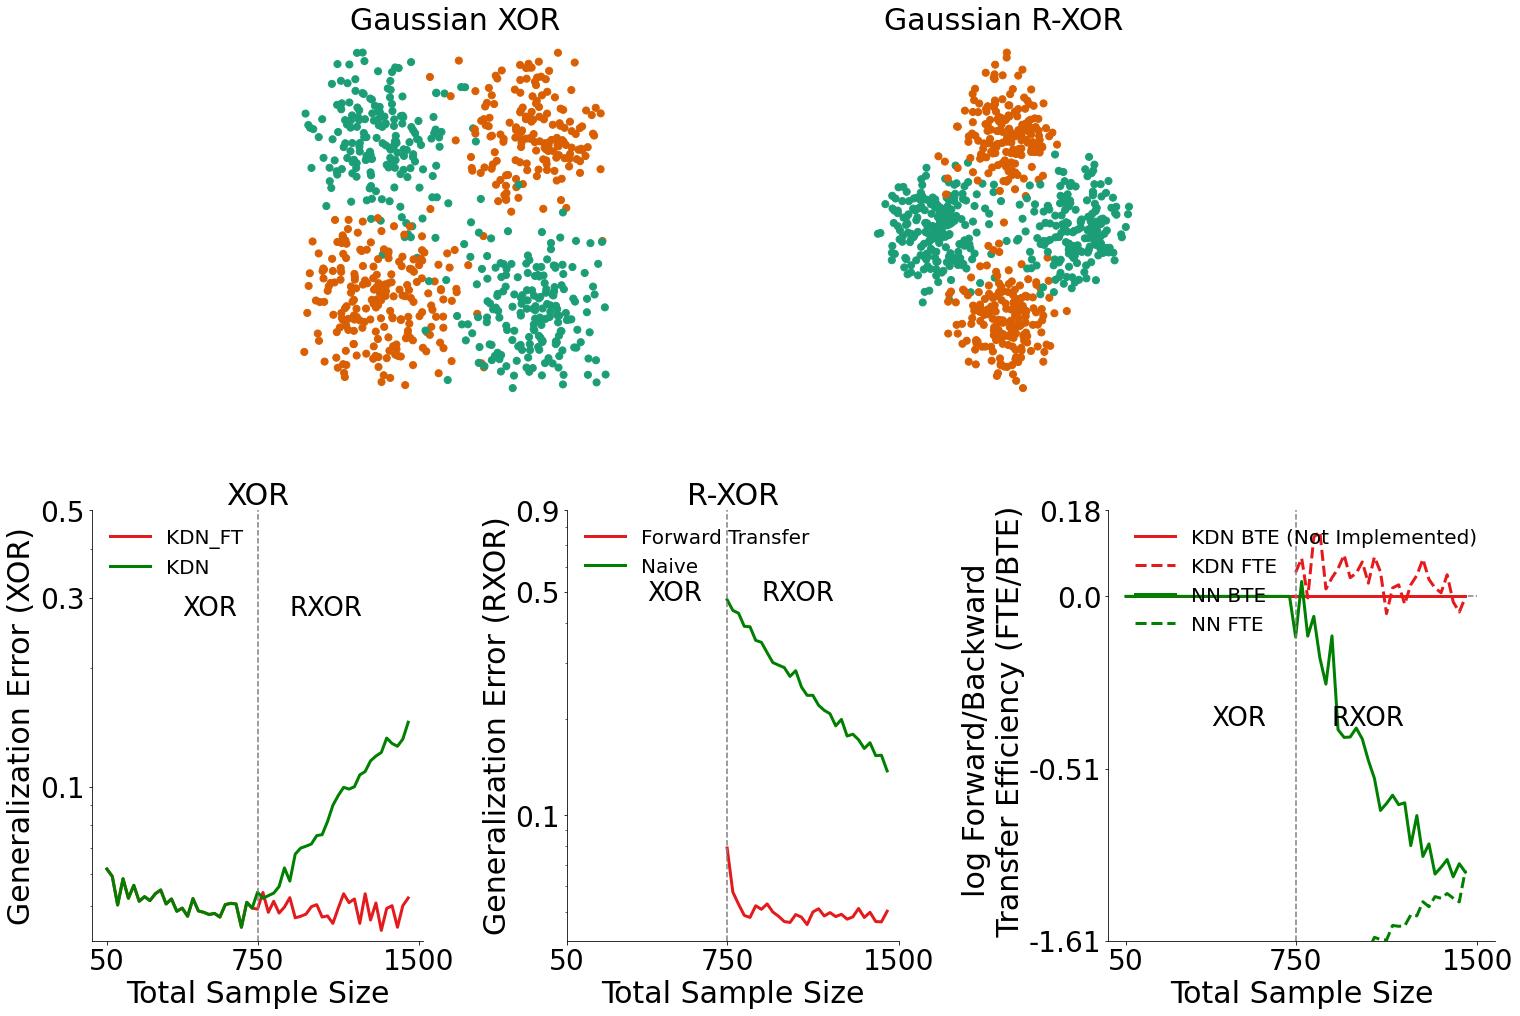

In [ ]:
# plot data
%matplotlib inline
plot_error_and_eff(n_xor, n_xnor, mean_error, mean_te, "XOR", "RXOR")